In [ ]:
# Install Google Cloud Vision
%pip install google-cloud-vision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
import io
import os
import pandas as pd
import sys
from google.colab import files
from google.cloud import vision
from IPython.display import Image, display, HTML

In [ ]:
# Import data from csv
# Download from here => https://drive.google.com/file/d/1cLULXBN_CpfBR_VuW0VviECCnOhKeGLW/view?usp=sharing
metrics_df = pd.read_csv("campaign_results.csv")
metrics_df.head()

,creative,reach,impressions,clicks,spend,conversions
0,c21,24710,33075,164,892.56,14
1,c22,17852,37644,85,683.61,2
2,c23,5350,6084,30,125.31,2
3,c25,473,494,3,18.73,0
4,c29,4868,6942,25,124.30,0


In [ ]:
# Get list of images
# Download from here => https://drive.google.com/drive/folders/1N3Fp_-KoyEml9CnSj0OnGUtzw4On0eQC?usp=sharing
path = "/content"
images = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.png')]

for image_name in images:
    display(Image(image_name, width=100, height=100))
    display(image_name.split("/")[-1])
    print()

In [ ]:
# Set Service Account
# Follow these instructions => https://cloud.google.com/vision/docs/setup
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ServiceAccount.json"

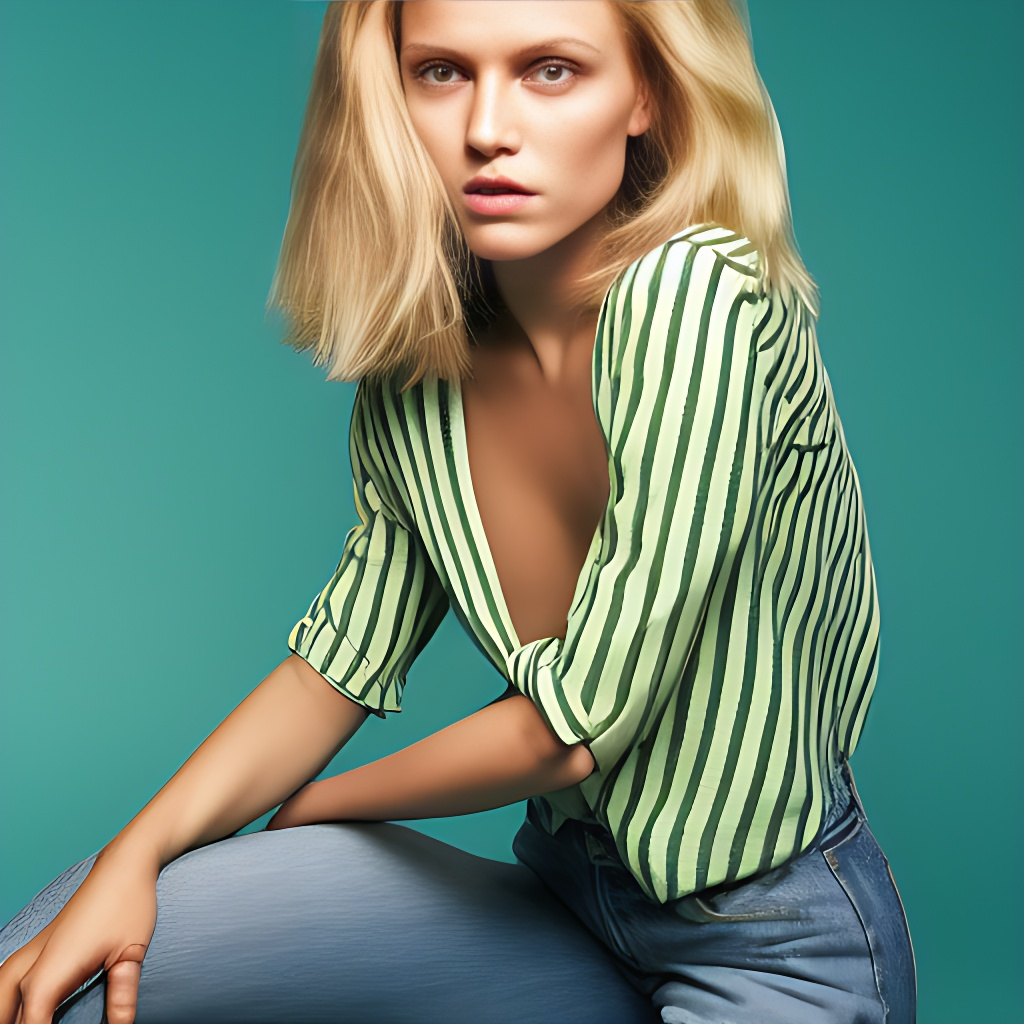

'c21.png'


Labels:
- Hair
- Joint
- Head
- Shoulder
- Eye
- Flash photography
- Neck
- Sleeve
- Dress
- Thigh


In [ ]:
# Instantiates a client
client = vision.ImageAnnotatorClient()

image_name = images[10]
# The name of the image file to annotate
file_name = os.path.abspath(image_name)

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)

# Performs label detection on the image file
response = client.label_detection(image=image)
labels = response.label_annotations

display(Image(image_name, width=100, height=100))
display(image_name.split("/")[-1])

print()
print('Labels:')
for label in labels:
    print("-", label.description)

In [ ]:
# process all images
creative_names = []
label_lists = []
for image_name in images:

    # The name of the image file to annotate
    file_name = os.path.abspath(image_name)

    # Loads the image into memory
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Performs label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations

    display(Image(image_name, width=100, height=100))
    creative_name = image_name.split("/")[-1]
    display(creative_name)

    print()
    print('Labels:')
    label_list = []
    for label in labels:
        label_list.append(label.description)
        print("-", label.description)

    creative_names.append(creative_name.split('.')[0])
    label_lists.append(','.join(label_list))
    print()

In [ ]:
data = []
for i in range(len(label_lists)):
    labels = label_lists[i].split(',')
    for l in labels:
        d_row = [creative_names[i], l]
        data.append(d_row)

df_labels = pd.DataFrame(data, columns=['creative', 'label'])
df_labels.head()

,creative,label
0,c39,Ball
1,c39,Still life photography
2,c39,Circle
3,c39,Sphere
4,c39,Electric blue


In [ ]:
lo = df_labels.columns[0]
ro = metrics_df.columns[0]
combo_df = df_labels.merge(metrics_df, left_on=lo, right_on=ro)
combo_df.head()

,creative,label,reach,impressions,clicks,spend,conversions
0,c39,Ball,1230,1481,11,62.29,2
1,c39,Still life photography,1230,1481,11,62.29,2
2,c39,Circle,1230,1481,11,62.29,2
3,c39,Sphere,1230,1481,11,62.29,2
4,c39,Electric blue,1230,1481,11,62.29,2


In [ ]:
# Create table that sums the result for each label:
# [label, creatives it appears in, sum of metric1, sum of metric2, ... ]

group = combo_df.groupby('label')

# Find all the creatives this label appears in and join them:
sum_df = pd.DataFrame(group.apply(lambda x: ",".join(x['creative'])), columns=['in_creatives'] )
sum_df['creative_count'] = sum_df['in_creatives'].apply(lambda x: len(x.split(',')))
sum_df.head()

,in_creatives,creative_count
label,,
Action figure,c44,1
Arm,"c3,c34,c25",3
Art,c44,1
Ball,"c39,c40,c40",3
Banana,c41,1


In [ ]:
# The remaining columns of the campaign results should be summed:
for column in combo_df.columns[2:]:
    sum_df[column] = group.apply(lambda x: x[column].sum())
sum_df.reset_index(inplace = True)
sum_df['CTR'] = sum_df['clicks'] / sum_df['impressions'] * 100
sum_df.head()

,label,in_creatives,creative_count,reach,impressions,clicks,spend,conversions,CTR
0,Action figure,c44,1,2780,3368,40,133.65,3,1.187648
1,Arm,"c3,c34,c25",3,3967,32369,132,716.75,20,0.407798
2,Art,c44,1,2780,3368,40,133.65,3,1.187648
3,Ball,"c39,c40,c40",3,2236,2579,15,83.93,2,0.581621
4,Banana,c41,1,10867,22280,55,254.89,4,0.246858


In [ ]:
# Show labels that appear in more than 3 creatives and not in all creatives
not_all = sum_df['creative_count'] < len(creative_names)
three_or_more = sum_df['creative_count'] >= 3
filtered_df = sum_df[not_all & three_or_more].sort_values(by='CTR', ascending=False)
filtered_df.head()

,label,in_creatives,creative_count,reach,impressions,clicks,spend,conversions,CTR
14,Circle,"c39,c40,c44",3,4513,5398,53,206.76,5,0.981845
30,Forehead,"c5,c23,c9",3,43700,57515,417,1721.37,27,0.725028
53,Neck,"c5,c4,c33,c3,c21,c25,c32",7,65382,87980,553,2525.60,37,0.628552
28,Flash photography,"c5,c33,c21,c7,c32,c35",6,70791,94816,577,2776.21,42,0.608547
66,Sleeve,"c5,c4,c33,c3,c21,c25,c7,c35,c9",9,81628,106543,627,3090.47,47,0.588495


In [ ]:
# Show worst performers
filtered_df.tail()

,label,in_creatives,creative_count,reach,impressions,clicks,spend,conversions,CTR
23,Face,"c22,c29,c34,c23,c32,c9",6,41633,95956,330,1913.05,28,0.343908
31,Gesture,"c33,c41,c7,c35,c9",5,30983,46648,155,930.75,15,0.332276
19,Electric blue,"c39,c40,c42,c41,c43",5,13727,25600,75,369.73,6,0.292969
79,White,"c4,c22,c29,c23,c25",5,32926,56392,159,1049.31,5,0.281955
35,Hairstyle,"c22,c3,c29",3,24341,46241,113,857.80,2,0.244372


In [ ]:
# Download Results
filename = 'creative_analysis.csv'
filtered_df.to_csv(filename, index=None)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>